<a href="https://colab.research.google.com/github/Pablix17/Inteligencia-Artificial-2023/blob/main/Taller_MNIST_Pablo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Librerias y Dataset**

Se importan las librerias necesarias para el preprocesamiento, la clasificacion y las medidas de desempeño.adicionalmente se estrae el dataset de MNIST desde keras y se divide en entrenamiento y prueba con el porcentaje recomendado.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import PolynomialFeatures
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


# Instrucciones generales.
## Conjunto de datos.

**Ajustes datos de entrada**: Pasar de un arreglo donde hay 60000 datos de ingreso de 28x28 a un ordenamiento de 784, para el caso de entrenamiento, el de prueba pasa de ser un arreglo de 10000 28x28 a 784.

In [ ]:
print(type(x_train))
print(type(y_train))
print((x_train.shape))
print((y_train.shape))
print((x_test.shape))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(60000, 28, 28)
(60000,)
(10000, 28, 28)


In [ ]:
x_train = x_train.reshape(60000, -1)
x_test = x_test.reshape(10000, -1)

In [ ]:
print(type(x_train))
print(type(y_train))
print((x_train.shape))
print((y_train.shape))
print((x_test.shape))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(60000, 784)
(60000,)
(10000, 784)


## Normalización

Se realiza la normalización de los datos, de tal manera que cuenten con media cero y desviacion estandar uno.Para cumplir este requerimeinto se emplea StandardScaler.

In [ ]:
QUIEROMINMAX=False
if QUIEROMINMAX:
  from  sklearn.preprocessing import MinMaxScaler
  scaleminmax = MinMaxScaler()
  scaleminmax.fit(x_train)
  x_train=scaleminmax.transform(x_train)
  x_test=scaleminmax.transform(x_test)
else:
  from  sklearn.preprocessing import StandardScaler
  scaleStandard = StandardScaler()
  scaleStandard.fit(x_train)
  x_train=scaleStandard.transform(x_train)
  x_test=scaleStandard.transform(x_test)

## PCA

con el fin de ejecutar una reduccion dimensional, se aplica PCA de los 784 componente, se cuentan con 2 graficas con distintas representaciones visuales de la varianza explicada, el primero es directamente la varianza explicada, la segunda es la suma acumulativa de la varianza explicada, de esa manera se ha de vizualisar con mayor facilidad cuanta información es representada hasta cada componente.

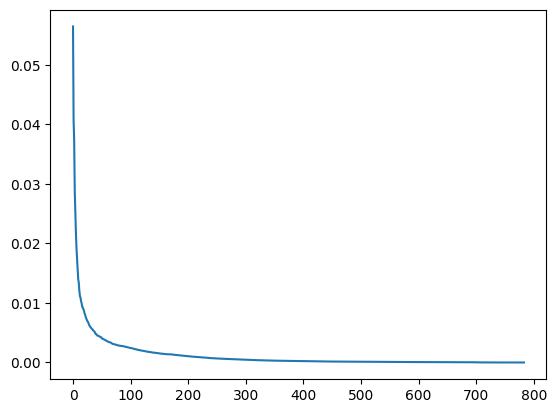

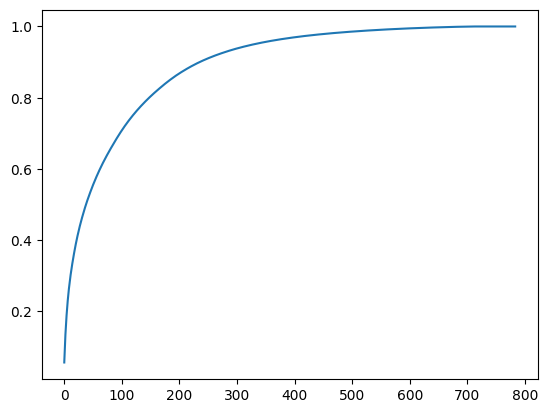

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
pca = PCA(n_components=784)
pca.fit(x_train)

plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
plt.figure()

Dadas las graficas se selecciona un valor de componentes que explique de forma satisfactoria los datos, sin tener que procesar los 784 componentes, para este caso se toman 215 las cuales dan sustento del 97% de la varianza explicada.

In [ ]:
componentes=215
print("con ", componentes, "componentes tenemos el ",np.cumsum(pca.explained_variance_ratio_)[componentes],"De la varianza explicada")

con  215 componentes tenemos el  0.883155681176413 De la varianza explicada


Finalmente se transforman los datos de test y train para que se rigan bajo las 215 componentes seleccionadas por PCA.

In [ ]:
pca2 = PCA(n_components=componentes)
pca2.fit(x_train)
x_tr=pca2.transform(x_train)
x_te=pca2.transform(x_test)

# Maquina de Soporte vectorial

Modelo kernel lineal

In [ ]:
scvlinear=SVC( kernel='linear')
scvlinear.fit(x_tr,y_train)

SVC(kernel='linear')

Desempeño

In [ ]:
mcc_svm_linear=matthews_corrcoef(y_test,scvlinear.predict(x_te))
print("el MCC de SVM linear es: ",mcc_svm_linear)

el MCC de SVM linear es:  0.9375583480007085


Modelo Polinomico orden 2

In [ ]:
scvPoly=SVC(kernel='poly',degree=2,coef0=0)
scvPoly.fit(x_tr,y_train)

SVC(coef0=0, degree=2, kernel='poly')

Desempeño

In [ ]:
mcc_svm_poly=matthews_corrcoef(y_test,scvPoly.predict(x_te))
print("el MCC de SVM Polinomico de orden 2 es: ",mcc_svm_poly)

el MCC de SVM Polinomico de orden 2 es:  0.9699924762072808


Modelo RBF

In [ ]:
scvrbf=SVC(kernel='rbf',gamma='scale')
scvrbf.fit(x_tr,y_train)

SVC()

Desempeño

In [ ]:
mcc_svm_rbf=matthews_corrcoef(y_test,scvrbf.predict(x_te))
print("el MCC de SVM RBF es: ",mcc_svm_rbf)

el MCC de SVM RBF es:  0.9661057203068159


In [ ]:
import pandas as pd
data = {
    'MODELO': ['Lineal', 'Polinomico Orden 2', 'RBF'],
    'DESEMPEÑO': [mcc_svm_linear,mcc_svm_poly ,mcc_svm_rbf ]

}
df = pd.DataFrame(data)
df.style.set_properties(**{'border': '1px solid black'})
print(df)

               MODELO  DESEMPEÑO
0              Lineal   0.937558
1  Polinomico Orden 2   0.969992
2                 RBF   0.966106


# KNN

Para realizar el modelo de knn, se emplea un for que permite recorrer por distintos valores de K y evaluar su desempeño, entre los parametros se tiene la distancia, que en este trabajo se manejo como euclideana, el dataset de MNIST maneja una representacion de pixeles por escala de grises, entonces una medida de distancia que se base en la diferencia de valores para realizar las comparaciones.

In [ ]:
k_range = range(1, 20)
distance='euclidean'
results = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k,weights='uniform',metric=distance, metric_params=None,algorithm='brute')
    #knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_tr, y_train)
    mcc_knn_uniform=matthews_corrcoef(y_test,knn.predict(x_te))
    print("el MCC de knn uniforme es: ",mcc_knn_uniform,'con k=',k)
    results.append(mcc_knn_uniform)

el MCC de knn uniforme es:  0.9489875373859415 con k= 1
el MCC de knn uniforme es:  0.9396736286052035 con k= 2
el MCC de knn uniforme es:  0.9497812471635859 con k= 3
el MCC de knn uniforme es:  0.947794542921795 con k= 4
el MCC de knn uniforme es:  0.9491167690456991 con k= 5
el MCC de knn uniforme es:  0.947675130426615 con k= 6
el MCC de knn uniforme es:  0.946337238239014 con k= 7
el MCC de knn uniforme es:  0.944571978306682 con k= 8
el MCC de knn uniforme es:  0.9438977171556641 con k= 9
el MCC de knn uniforme es:  0.9426782619141456 con k= 10
el MCC de knn uniforme es:  0.9433429805484609 con k= 11
el MCC de knn uniforme es:  0.942344257554764 con k= 12
el MCC de knn uniforme es:  0.9430144377519794 con k= 13
el MCC de knn uniforme es:  0.9414584080463219 con k= 14
el MCC de knn uniforme es:  0.9416819016212565 con k= 15
el MCC de knn uniforme es:  0.9406852387735498 con k= 16
el MCC de knn uniforme es:  0.9400194280062516 con k= 17
el MCC de knn uniforme es:  0.938910722165653

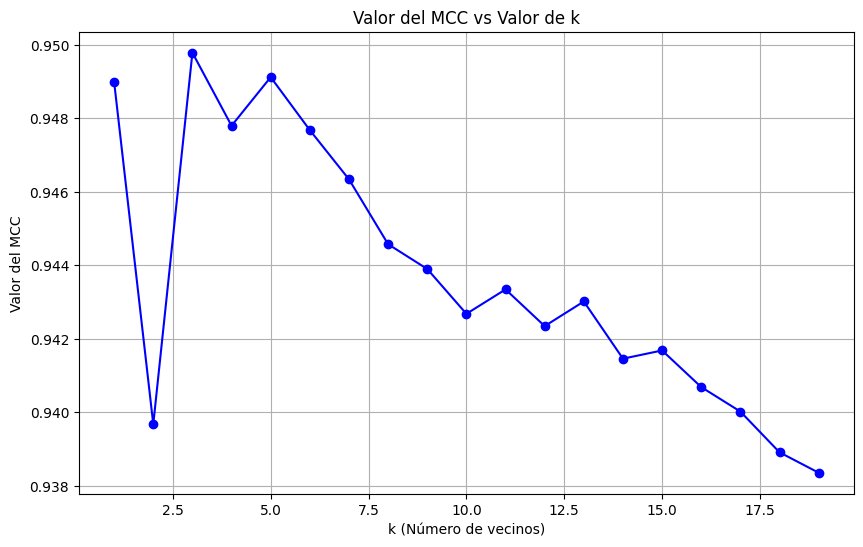

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, results, marker='o', linestyle='-', color='b')
plt.title('Valor del MCC vs Valor de k')
plt.xlabel('k (Número de vecinos)')
plt.ylabel('Valor del MCC')
plt.grid(True)
plt.show()

Pesos basados en distancia

In [ ]:
k_range = range(1, 20)
distance='euclidean'
results1 = []
for k in k_range:
    knnd = KNeighborsClassifier(n_neighbors = k,weights='distance',metric=distance, metric_params=None,algorithm='brute')
    knnd.fit(x_tr, y_train)
    mcc_knnd_distance=matthews_corrcoef(y_test,knnd.predict(x_te))
    print("el MCC de knn con distancias es: ",mcc_knnd_distance,'con k=',k)
    results1.append(mcc_knnd_distance)


el MCC de knn con distancias es:  0.9489875373859415 con k= 1
el MCC de knn con distancias es:  0.9489875373859415 con k= 2
el MCC de knn con distancias es:  0.9518811002670023 con k= 3
el MCC de knn con distancias es:  0.9522155296290958 con k= 4
el MCC de knn con distancias es:  0.9504411189514035 con k= 5
el MCC de knn con distancias es:  0.9524381334542652 con k= 6
el MCC de knn con distancias es:  0.9474408403806104 con k= 7
el MCC de knn con distancias es:  0.9488902029323363 con k= 8
el MCC de knn con distancias es:  0.9453377356882392 con k= 9
el MCC de knn con distancias es:  0.9463385698949758 con k= 10
el MCC de knn con distancias es:  0.9444492687628003 con k= 11
el MCC de knn con distancias es:  0.9451187131795717 con k= 12
el MCC de knn con distancias es:  0.94434280961714 con k= 13
el MCC de knn con distancias es:  0.9446753005908504 con k= 14
el MCC de knn con distancias es:  0.9429012706127323 con k= 15
el MCC de knn con distancias es:  0.9432366222977177 con k= 16
el 

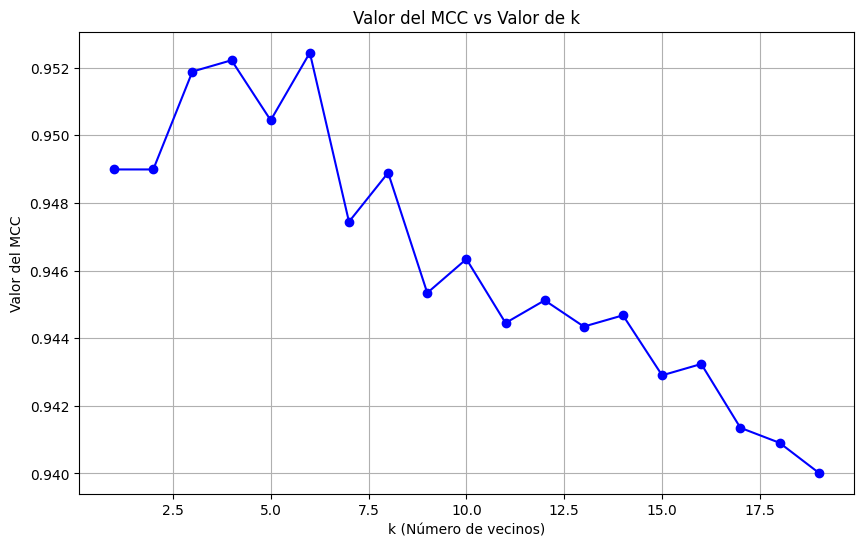

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, results1, marker='o', linestyle='-', color='b')
plt.title('Valor del MCC vs Valor de k')
plt.xlabel('k (Número de vecinos)')
plt.ylabel('Valor del MCC')
plt.grid(True)
plt.show()

# Regresión Logistica

In [ ]:
porcentaje = 0.20
filas_seleccionadas = int(  x_tr.shape[0] * porcentaje)
indices_aleatorios = np.random.choice(x_tr.shape[0], filas_seleccionadas, replace=False)
arreglo_seleccionado = x_tr[indices_aleatorios]
y_seleccionado = y_train[indices_aleatorios]

In [ ]:
poli=PolynomialFeatures(degree=2, interaction_only=False, include_bias=True, order='C')
Xpoli=poli.fit_transform(arreglo_seleccionado)
xtpoli=poli.fit_transform(x_te)

In [ ]:
from sklearn.linear_model import LogisticRegression
reg2 = LogisticRegression(fit_intercept=False,max_iter=350)
reg2.fit(Xpoli, y_seleccionado)
print(reg2.score(Xpoli, y_seleccionado))
print(reg2.coef_)

1.0
[[-3.22586700e-03  5.40526504e-02 -6.69861203e-03 ... -1.23457691e-03
  -8.90756486e-04 -1.39117014e-03]
 [-6.00124280e-03  1.22896957e-02  1.18590168e-03 ... -5.97368573e-03
  -1.01679841e-03 -1.02236993e-03]
 [ 1.83896626e-03  8.38729347e-03 -1.40608203e-02 ...  4.68950805e-03
   8.47683202e-05  2.40535293e-04]
 ...
 [-2.42461756e-03  1.24042509e-03  2.04395479e-02 ...  1.89257993e-03
  -2.14090613e-03  1.40133258e-03]
 [ 1.30218817e-02 -5.83656041e-02 -2.61362226e-02 ...  4.94793688e-03
   1.78745793e-03  5.30046435e-03]
 [ 8.55192725e-04 -3.04527807e-02  1.79036778e-02 ... -1.88959285e-03
   1.07445937e-03  1.83385313e-03]]


In [ ]:
mcc_pollog_regression=matthews_corrcoef(y_test,reg2.predict(xtpoli))
print("el MCC de regresión logistica polinomica es: ",mcc_pollog_regression)

el MCC de regresión logistica polinomica es:  0.9571027631140236


In [ ]:
reg = LogisticRegression(max_iter=1000)
reg.fit(x_tr, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
mcc_log_regression=matthews_corrcoef(y_test,reg.predict(x_te))
print("el MCC de regresión logistica  es: ",mcc_log_regression)

el MCC de regresión logistica  es:  0.91998407510011


In [ ]:
import pandas as pd
data = {
    'MODELO': ['Datos Originales', 'Datos expandidos'],
    'DESEMPEÑO': [mcc_log_regression,mcc_pollog_regression ]

}
df = pd.DataFrame(data)
df.style.set_properties(**{'border': '1px solid black'})
print(df)

             MODELO  DESEMPEÑO
0  Datos Originales   0.920096
1  Datos expandidos   0.957103


## Discución de Resultados

In [ ]:
import pandas as pd
data = {
    'CLASIFICADOR': ['SVM', 'SVM', 'SVM','KNN','KNN','REG Logistica','REG Logistica'],
    'MODELO': ['Lineal', 'Polinomico Orden 2', 'RBF','Uniforme', 'Distancia','Datos Originales', 'Datos expandidos'],
    'DESEMPEÑO': [mcc_svm_linear, mcc_svm_poly , mcc_svm_rbf, results[2], results1[5], mcc_log_regression, mcc_pollog_regression],
    'RANKING': ['6', '1', '2','5','4','7','3'],
}
df = pd.DataFrame(data)
df.style.set_properties(**{'border': '1px solid black'})
print(df)

    CLASIFICADOR              MODELO  DESEMPEÑO RANKING
0            SVM              Lineal   0.937558       6
1            SVM  Polinomico Orden 2   0.969992       1
2            SVM                 RBF   0.966106       2
3            KNN            Uniforme   0.949781       5
4            KNN           Distancia   0.952438       4
5  REG Logistica    Datos Originales   0.919984       7
6  REG Logistica    Datos expandidos   0.957103       3


Para empezar, se puede comparar en términos generales por métodos clasificación, basándose en la medida de desempeño proporcionada por el coeficiente de correlación de Matthews sobre el conjunto de prueba y el tiempo que le toma realizar el procesamiento del modelo.

Lo primero que se resalta es que el que cuenta en comparación con peor desempeño es la regresión logística con datos originales siendo aproximadamente del 92%, su procesamiento no es tan demorado no como en el otro caso de regresión logística, la polinomial, en este caso tiene un coeficiente de Matthews superior para ser específicos es el tercero mejor. Pero es también la que mas tiempo le toma generar el modelo, dado que no solo es con los datos originales sino al ser polinomial incluye los pares generados por PolinomialFeatures, por los motivos mencionados, ninguno de los dos modelos de regresión logística es el seleccionado como el mejor clasificador de este trabajo. También es importante destacar que en el caso polinomial no se pudo incluir todo el conjunto de entrenamiento, dado que para conjuntos de datos grandes el método no es lo sufrientemente robusto para manejarlos.

Continuando con KNN se realizaron 20 pruebas con distintos k, se evidencio que el desempeño tanto para la uniforme, como para la basada en distancias, caía al ir aumentando la cantidad de vecinos por ello se tomaron los mejores de cada una siendo en el caso de uniforme la mejor 3 vecinos, con un desempeño aproximado del 95% y en la de distancias 6 vecinos con un aproximado de 95.2%, los dos valores son buenos estimados, la demora computacional se halla es en iterar k veces para descubrir en cual se halla el mejor caso y luego en la comparación con cada distancia , no es un mal método de clasificación pero hay mejores y más rápidos , también es notorio que es sensible a la elección de hiperparametros y métricas, por ello estos se encuentran en los puestos 5 y 4 respectivamente.

Por ultimo queda Maquinas de soporte vectorial, las cuales tuvieron el mejor desempeño en promedio, computacionalmente son moderadamente demoradas, pero cumple su objetivo, también se evidencio una sensibilidad ante el kernel seleccionado, el cual marcó la diferencia entre cual fue el mejor de los 3 modelos, el lineal es simple y el usado comúnmente, pero en este caso no tuvo un desempeño destacable a comparación de los otros dos que se pelean el primer puesto, por una leve diferencia, polinómico de orden 2 se lleva el reconocimiento como mejor método de clasificación para el caso planteado.
